In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv',
                 encoding='latin-1', header=None)

/tmp/ipython-input-1918903886.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('training.1600000.processed.noemoticon.csv',


In [8]:
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

In [9]:
df['target'] = df['target'].replace(4, 1)

In [14]:
print(df.head())

   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


In [15]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1227961 entries, 0 to 1227960
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1227961 non-null  int64 
 1   ids     1227961 non-null  object
 2   date    1227961 non-null  object
 3   flag    1227960 non-null  object
 4   user    1227960 non-null  object
 5   text    1227961 non-null  object
dtypes: int64(1), object(5)
memory usage: 56.2+ MB
None


In [16]:
print(df['target'].value_counts())

target
1    800000
0    427961
Name: count, dtype: int64


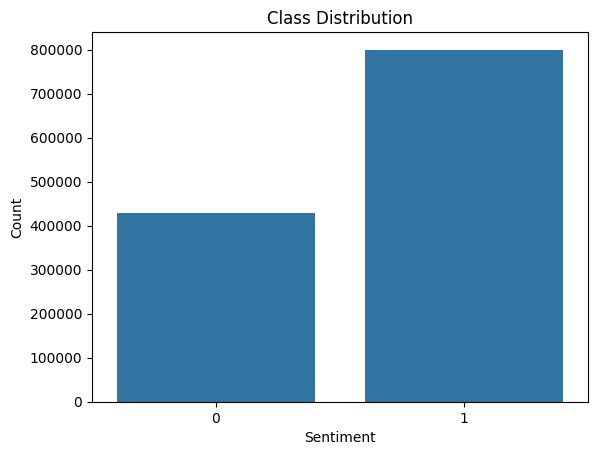

In [17]:
sns.countplot(x='target', data=df)
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [18]:
df['target'] = df['target'].replace(4, 1)

In [19]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [20]:
df['text'] = df['text'].astype(str)

In [22]:
df = df.sample(n=1000000, random_state=42)


In [23]:
def preprocess_text(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    words = text.split()
    cleaned_words = [stemmer.stem(w) for w in words if w not in stop_words]
    return " ".join(cleaned_words)

print("Preprocessing text... this may take a while.")

# --- THE FIX IS HERE ---
# Ensure all data in 'text' column are strings
df['text'] = df['text'].astype(str)
# -----------------------

df['cleaned_text'] = df['text'].apply(preprocess_text)
print("Preprocessing complete.")

Preprocessing text... this may take a while.
Preprocessing complete.


In [24]:
vectorizer = TfidfVectorizer(max_features=5000) # Limit features for speed
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['target']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
model = LogisticRegression(max_iter=1000)
print("Training model...")
model.fit(X_train, y_train)
print("Training complete.")

Training model...
Training complete.


In [27]:
y_pred = model.predict(X_test)

In [28]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.7931

Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.60      0.67     69707
           1       0.81      0.89      0.85    130293

    accuracy                           0.79    200000
   macro avg       0.78      0.75      0.76    200000
weighted avg       0.79      0.79      0.79    200000



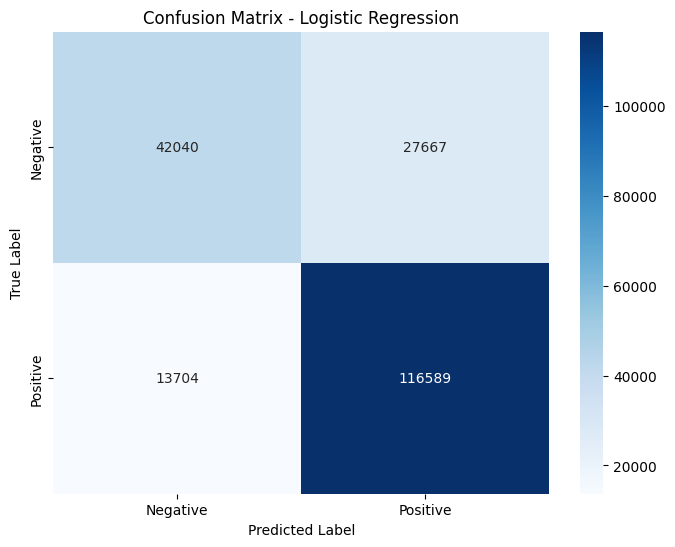

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [37]:
def predict_tweet(tweet):
    """
    Takes a raw tweet string, preprocesses it, and predicts sentiment.
    """
    # 1. Preprocess
    cleaned_tweet = preprocess_text(tweet)

    # 2. Vectorize using the FITTED vectorizer
    # Note: Use transform(), NOT fit_transform()
    tweet_vector = vectorizer.transform([cleaned_tweet])

    # 3. Predict
    prediction = model.predict(tweet_vector)
    probability = model.predict_proba(tweet_vector)

    sentiment = "Positive" if prediction[0] == 1 else "Negative"
    confidence = np.max(probability)

    return sentiment, confidence

# --- Test the Prediction ---
test_tweets = [
    "an't wait to see the new Spider-Man movie tonight!",


]

print("-" * 30)
print("Custom Predictions:")
for t in test_tweets:
    sent, conf = predict_tweet(t)
    print(f"Tweet: {t}\nPrediction: {sent} (Confidence: {conf:.2f})\n")

------------------------------
Custom Predictions:
Tweet: an't wait to see the new Spider-Man movie tonight!
Prediction: Positive (Confidence: 0.91)

